## <center> Assignment 2: Camera Calibration <center>

Note: If you have opened Report.pdf file I would recommend opening Report.html file which is much better looking than this.


The assignment is done in Python with the help of OpenCV for detecting corners of the checkerboard. Everything else is done completely using NumPy and Scipy and plots are made using Matplotlib. The entire implementation is based on the theory and the mathematics of Projective Geometry explained in class. The implementation includes three plots, one of which (checkerboard plots) is a 3D plot. You can run the "main.py" file and visualize the 3D plot(you can rotate the image also for clarity). If you want to visualize the 3D plot in Ipython Notebook please uncomment the "%matplotlib notebook" line in the cell above the corresponding plot. 

The implementation is done using Ipython Notebook, although the notebook is also converted into .py file. Both Ipython Notebook and the Python files are submitted. Instead of a separate PDF, the Ipython Notebook has been converted to PDF and submitted where the implementation is clearly explained with plots. 

Submitted Files:

main.py <br/>
Camera Calibration(OpenCV).ipynb <br/>
Report.pdf <br/>
Report.html (better visualization)  <br/>  
Plots in the image folder <br/>

In [16]:
%matplotlib inline
import cv2
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

### Step 2: Reading the Images and Extracting Checkerboard corners

In [37]:
# Load images
im1 = cv2.imread("../images/img1.png")
im2 = cv2.imread("../images/img2.png")
im3 = cv2.imread("../images/img3.png")
im4 = cv2.imread("../images/img4.png")
im5 = cv2.imread("../images/img5.png")

In [38]:
# Detecting corners for image using OpenCV 

ret1, corners1 = cv2.findChessboardCorners(im1, (8, 6))
ret2, corners2 = cv2.findChessboardCorners(im2, (8, 6))
ret3, corners3 = cv2.findChessboardCorners(im3, (8, 6))
ret4, corners4 = cv2.findChessboardCorners(im4, (8, 6))
ret5, corners5 = cv2.findChessboardCorners(im5, (8, 6))

In [39]:
# Collapsing the second dimension

corners1 = np.squeeze(corners1)
corners2 = np.squeeze(corners2)
corners3 = np.squeeze(corners3)
corners4 = np.squeeze(corners4)
corners5 = np.squeeze(corners5)

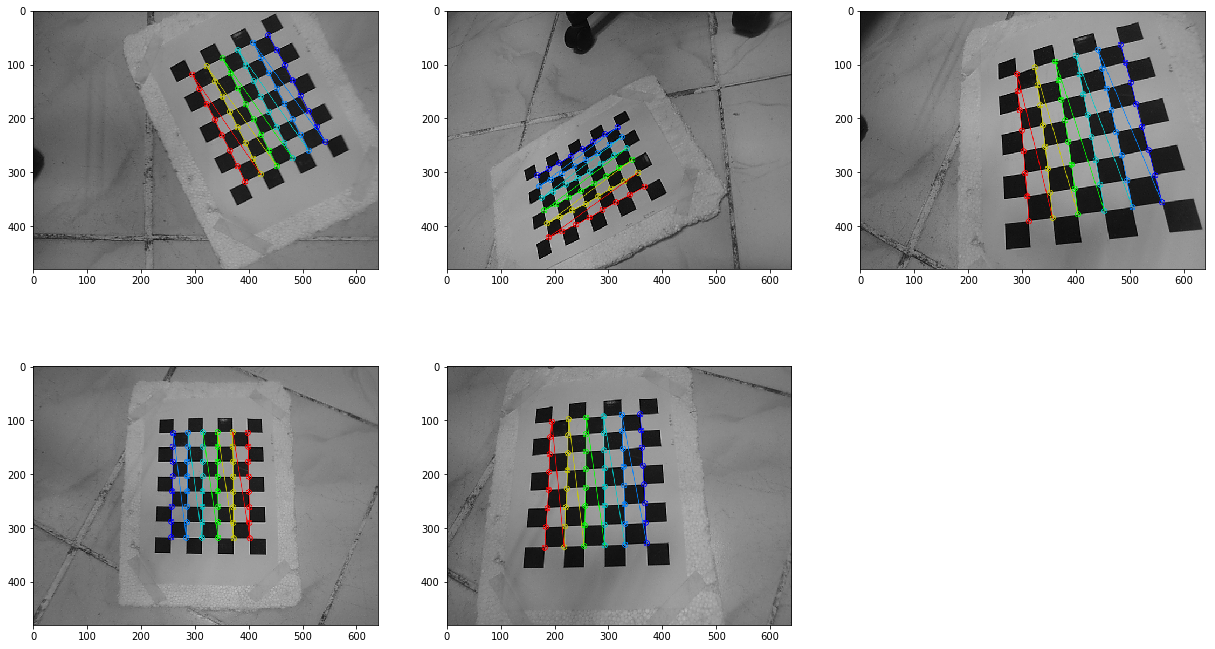

In [40]:
# Plotting the detected corners


plt.rcParams['figure.figsize'] = 21, 12

plt.subplot(231)
im_vis1=im1.copy()
cv2.drawChessboardCorners(im_vis1, (8,6), corners1, ret1) 
plt.imshow(im_vis1)
# plt.show()

plt.subplot(232)
im_vis2=im2.copy()
cv2.drawChessboardCorners(im_vis2, (8,6), corners2, ret2) 
plt.imshow(im_vis2)
# plt.show()

plt.subplot(233)
im_vis3=im3.copy()
cv2.drawChessboardCorners(im_vis3, (8,6), corners3, ret3) 
plt.imshow(im_vis3)
# plt.show()

plt.subplot(234)
im_vis4=im4.copy()
cv2.drawChessboardCorners(im_vis4, (8,6), corners4, ret4) 
plt.imshow(im_vis4)
# plt.show()

plt.subplot(235)
im_vis5=im5.copy()
cv2.drawChessboardCorners(im_vis5, (8,6), corners5, ret5) 
plt.imshow(im_vis5)
plt.savefig("../images/Visualizing the detected cornerpoints.jpg")
plt.show()


In [41]:
# Assuming the checkerboard is in X-Y plane and setting Z=0

# In World Frame

x, y = np.meshgrid(range(8), range(6))

w_points = np.hstack([x.reshape(48,1), y.reshape(48, 1), np.zeros((48,1))])*24

### Step 4: Calculating the Homographies

In [42]:
#### Estimating the Homography 

# Building the M matrix 

def get_a_vectors(x, y, X, Y):
    a_x = [-X, -Y, -1, 0, 0, 0, x*X, x*Y, x]
    a_y = [0, 0, 0, -X, -Y, -1, y*X, y*Y, y]
    return np.array([a_x, a_y])

def build_M_matrix(corners, w_points):
    num_points = 48
    M = []
    for i in range(num_points):
        a = get_a_vectors(corners[i][0], corners[i][1], w_points[i][0], w_points[i][1])
        if M == []:
            M = a
            continue
        M = np.vstack([M, a])
    return M

def estimate_homography(corners, w_points):
    M = build_M_matrix(corners, w_points)
    # applying Singular Value Decomposition(SVD)
    U, S, V = np.linalg.svd(M)
    H = V[-1].reshape(3,3)
    return H/H[2,2]

H = estimate_homography(corners1, w_points)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


### Step5: Building a Linear System and solving for K

In [43]:
### Estimating B matrix,  B = trans(K_inv)*K_inv

def get_v(H, i, j):
    return np.array([H[0,i]*H[0,j], H[0,i]*H[1,j]+H[1,i]*H[0,j],\
            H[2,i]*H[0,j]+H[0,i]*H[2,j], H[1,i]*H[1,j],\
            H[2,i]*H[1,j]+H[1,i]*H[2,j], H[2,i]*H[2,j]])


# Using only 4 image to do estimate the calibration matrix 
# There is some problem with image3 (not aligned with other images)
corners = [corners1, corners2, corners4, corners5]

def estimate_B(corners, w_points):
    V = []
    for i in range(len(corners)):
        H = estimate_homography(corners[i], w_points)
        v12 = get_v(H, 0, 1)
        v11 = get_v(H, 0, 0)
        v22 = get_v(H, 1, 1)
        v = np.array([v12, v11-v22])
        if V == []:
            V = v
            continue
        V = np.vstack([V, v])
    # Applying SVD
    U, S, V_ = np.linalg.svd(V)
    b = V_[-1]  # Taking the column corresponding to least singular value
    B = np.array([[b[0], b[1], b[2]], [b[1], b[3], b[4]], [b[2], b[4], b[5]]])
    return B
    
def is_pos_def(x):
    # Checks for positive definiteness
    return np.all(np.linalg.eigvals(x) > 0)

def convert_to_pos_def(B):
    # Converts perturbed B matrix to positive definite 
    B_ = (B + B.T)/2.
    while(True):
        eigenvalues = np.linalg.eigvals(B_)
        print(eigenvalues)
        lambda_ = np.min(eigenvalues)
        delta = 10**(-12)
        if lambda_ < 0:
            B_ = B_ + (lambda_**2)*np.identity(3)
        elif lambda_ == 0:
            B_ = B_ + delta*np.identity(3)
        else:
            break
    return B_
  
def estimate_intrinsics(corners, w_points):
    # Estimating K from B matrix
    B = estimate_B(corners, w_points)
    if ~is_pos_def(B):
        B = convert_to_pos_def(B)
    K_inv = scipy.linalg.cholesky(B, lower=False)
    K = np.linalg.inv(K_inv)
    return K/K[-1,-1] # Dividing by last element of last row to make it homogeneous

In [44]:
print("K matrix is : ")

estimate_intrinsics(corners, w_points)

K matrix is : 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


array([[534.35128479,  -5.93806184, 291.43743552],
       [  0.        , 536.06946612, 234.34519391],
       [  0.        ,   0.        ,   1.        ]])

### Step6: Factoring out R and t and plotting the checkerboard points

In [45]:
def estimate_extrinsics(corners, w_points):
    K = estimate_intrinsics(corners, w_points)
    R_matrices = []
    t_vectors = []
    corners = [corners1,corners2,corners3,corners4,corners5]
    for i in range(len(corners)):
        H = estimate_homography(corners[i], w_points)
        h1 = H[:,0]
        h2 = H[:,1]
        h3 = H[:,2]
        lambda_ = 1./np.linalg.norm(np.dot(np.linalg.inv(K), h1))
        r1 = np.dot(np.linalg.inv(K),h1)*lambda_
        r2 = np.dot(np.linalg.inv(K),h2)*lambda_
        r3 = np.cross(r1, r2)
        t  = np.dot(np.linalg.inv(K),h3)*lambda_
        R_matrices.append(np.dstack([r1,r2,r3]))
        t_vectors.append(t)
    return np.squeeze(np.array(R_matrices)), np.squeeze(np.array(t_vectors))
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


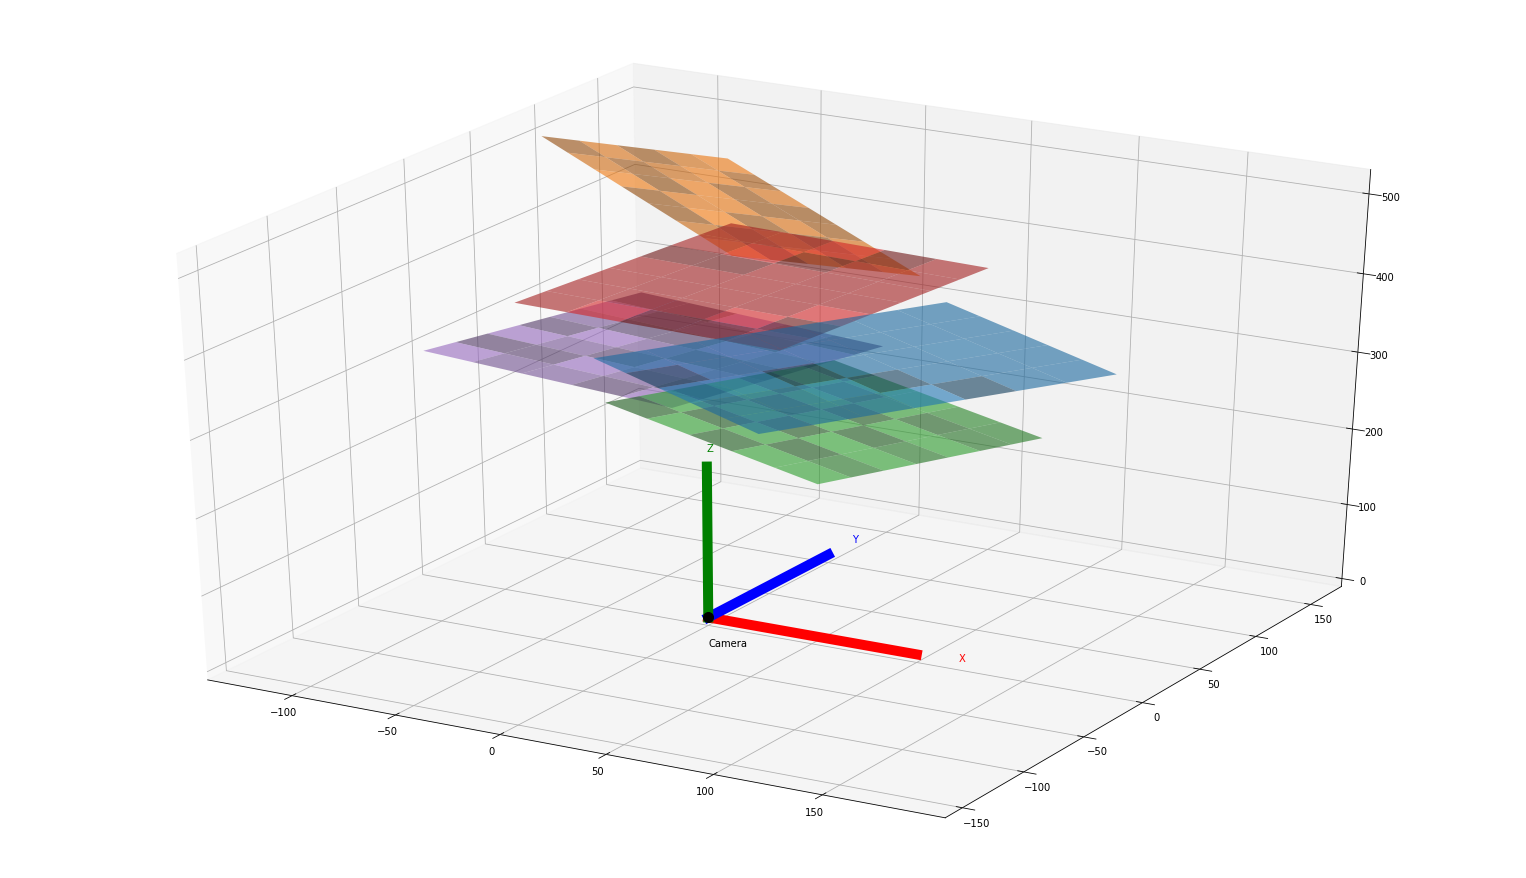

In [46]:
# %matplotlib notebook  # To visualize in 3d uncomment this line
 

fig = plt.figure()
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
ax = Axes3D(fig)
# ax.view_init(-40, 0)

def plot_extrinsics(corners, w_points):
    K = estimate_intrinsics(corners, w_points)
    R_matrices, t_vectors = estimate_extrinsics(corners, w_points)
    x, y = np.meshgrid(range(8), range(6))
    corners = [corners1,corners2,corners3,corners4,corners5]
    for i in range(len(corners)):
        R = R_matrices[i,:,:]
        t = t_vectors[i,:]
#         print(t.shape)
        T = np.squeeze(np.hstack([R, t.reshape(-1,1)]))
        X = np.squeeze(np.hstack([w_points, np.ones((48,1))]))
        X_proj = np.dot(T, X.T).T
        ax.plot_surface(X_proj[:,0].reshape(6,8), X_proj[:,1].reshape(6,8), X_proj[:,2].reshape(6,8), alpha=0.6)

plot_extrinsics(corners, w_points)
ax.plot([0, 100],[0, 0], [0, 0], linewidth=10, color='r',alpha=1.0)
ax.text(120, 0, 0, "X", color='red')
ax.plot([0, 0],[0, 100], [0, 0], linewidth=10, color='b',alpha=1.0)
ax.text(0, 120, 0, "Y", color='b')
ax.plot([0, 0],[0, 0], [0, 200], linewidth=10, color='g',alpha=1.0)
ax.text(0, 0, 220, "Z", color='g')
ax.plot([0],[0],[0], markerfacecolor='k', markeredgecolor='k', marker='o', markersize=10, alpha=1.0)
ax.text(0, 0, -40, "Camera", color='k')
plt.savefig("../images/Checkerboardpoints_plot_in_camera_frame.jpg")
plt.show()


### Step7: Evaluating the Calibration 

In [49]:
def reproject_corners(corners, w_points):
    K = estimate_intrinsics(corners, w_points)
    R_matrices, t_vectors = estimate_extrinsics(corners, w_points)
    x, y = np.meshgrid(range(8), range(6))
    corners = [corners1,corners2,corners3,corners4,corners5]
    mean_error = []
    for i in range(len(corners)):
        R = R_matrices[i,:,:]
        t = t_vectors[i,:]
        T = np.squeeze(np.hstack([R, t.reshape(-1,1)]))
        X = np.squeeze(np.hstack([w_points, np.ones((48,1))]))
        X_proj = np.dot(K, np.dot(T, X.T))
        X_proj = np.transpose(X_proj, (1,0))/X_proj[2,:][:,None]
        mean_error.append(np.mean(np.abs(corners[i] - X_proj[:,:2]).ravel()))
    plt.bar(range(1,6), mean_error)
    plt.xlabel("Image Number")
    plt.ylabel("Mean Reprojection Error (in pixels)")
    plt.title("Reprojection Result after estimating intrinsic and extrinsic parameters.")
    plt.savefig("../images/Reprojection Error Barplot.jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


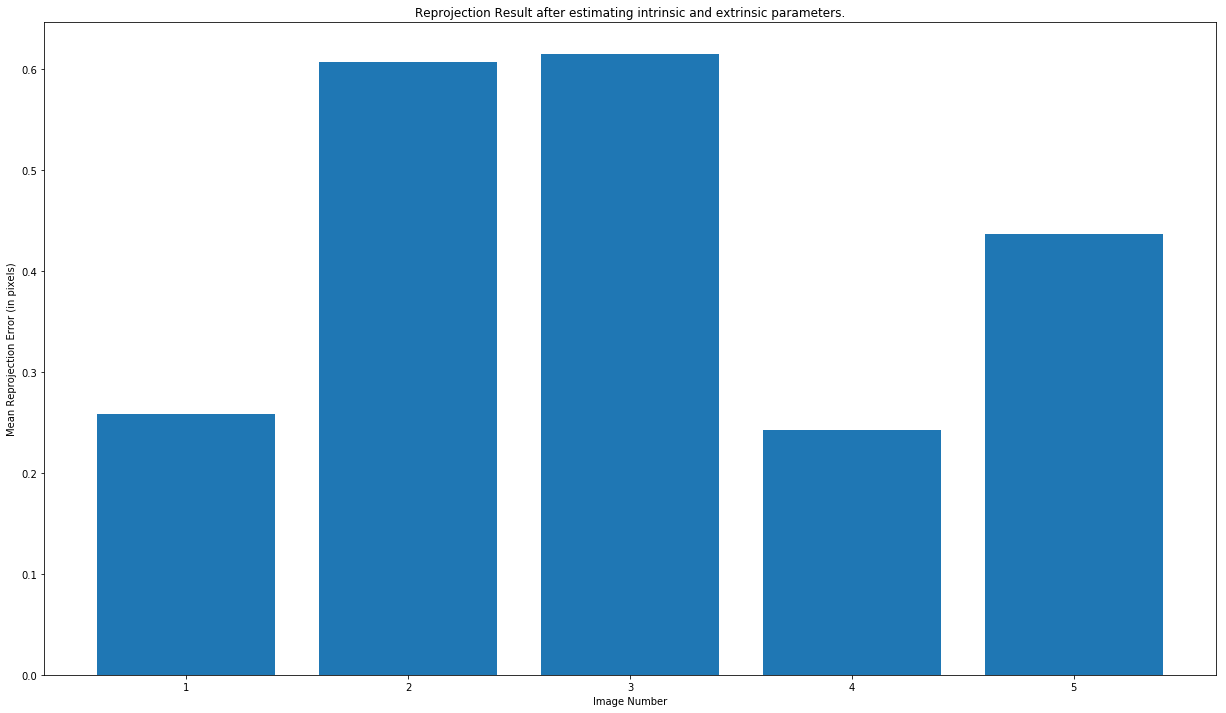

In [50]:
reproject_corners(corners, w_points)